lamda 2: Epoch 0 Loss: 0.1210
lamda 2: Epoch 1 Loss: 0.1108
lamda 2: Epoch 2 Loss: 0.1128
lamda 2: Epoch 3 Loss: 0.1131
lamda 2: Epoch 4 Loss: 0.1096
lamda 2: Epoch 5 Loss: 0.1086
lamda 2: Epoch 6 Loss: 0.1129
lamda 2: Epoch 7 Loss: 0.1085
lamda 2: Epoch 8 Loss: 0.1092
lamda 2: Epoch 9 Loss: 0.1075
lamda 2: Epoch 10 Loss: 0.1114
lamda 2: Epoch 11 Loss: 0.1065
lamda 2: Epoch 12 Loss: 0.1132
lamda 2: Epoch 13 Loss: 0.1089
lamda 2: Epoch 14 Loss: 0.1103
lamda 2: Epoch 15 Loss: 0.1047
lamda 2: Epoch 16 Loss: 0.1064
lamda 2: Epoch 17 Loss: 0.1061
lamda 2: Epoch 18 Loss: 0.1039
lamda 2: Epoch 19 Loss: 0.1136
lamda 2: Epoch 20 Loss: 0.1086
lamda 2: Epoch 21 Loss: 0.1022
lamda 2: Epoch 22 Loss: 0.1020
lamda 2: Epoch 23 Loss: 0.0988
lamda 2: Epoch 24 Loss: 0.1007
lamda 2: Epoch 25 Loss: 0.0990
lamda 2: Epoch 26 Loss: 0.1054
lamda 2: Epoch 27 Loss: 0.1038
lamda 2: Epoch 28 Loss: 0.1050
lamda 2: Epoch 29 Loss: 0.1068
lamda 2: Epoch 30 Loss: 0.0995
lamda 2: Epoch 31 Loss: 0.1062
lamda 2: Epoch 32 

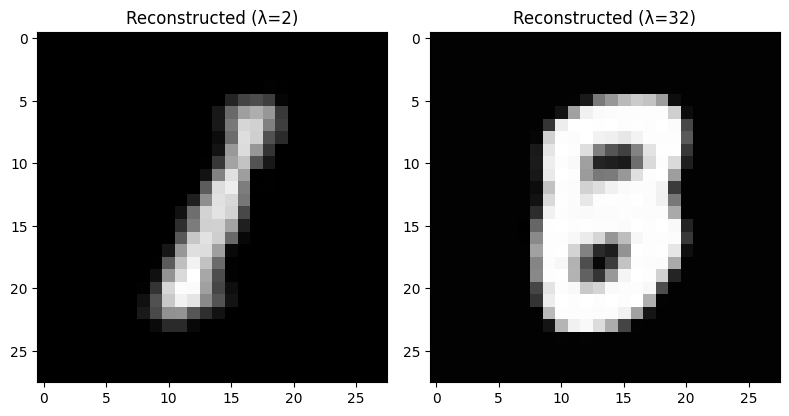

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# Define the Convolutional Autoencoder model class
class ConvAutoencoder(nn.Module):
    def __init__(self, lambda_value):
        super(ConvAutoencoder, self).__init__()
        self.lambda_value = lambda_value
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # 1x28x28 -> 16x28x28
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x28x28 -> 16x14x14
            nn.Conv2d(16, 8, kernel_size=3, padding=1),  # 16x14x14 -> 8x14x14
            nn.ReLU(),
            nn.MaxPool2d(2)  # 8x14x14 -> 8x7x7
        )
        # Bottleneck layer
        self.bottleneck = nn.Sequential(
            nn.Flatten(),  # 8x7x7 => 392
            nn.Linear(392, lambda_value),  # Lambda
            nn.ReLU()
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(lambda_value, 392),  # Lambda => 392
            nn.ReLU(),
            nn.Unflatten(1, (8, 7, 7)),  # 392 => 8x7x7
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x7x7 => 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x14x14 => 16x28x28
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),  # 16x28x28 => 1x28x28
            #nn.ReLU()  
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = self.bottleneck(encoded)
        decoded = self.decoder(encoded)
        return decoded

# Load and preprocess the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Instantiate the autoencoder for λ = 2 and λ = 32
autoencoder_lambda_2 = ConvAutoencoder(lambda_value=2)
autoencoder_lambda_32 = ConvAutoencoder(lambda_value=32)

# Define the loss function (L1 loss) and optimizer (Adam)
criterion = nn.L1Loss()
optimizer_lambda_2 = optim.Adam(autoencoder_lambda_2.parameters(), lr=0.001)
optimizer_lambda_32 = optim.Adam(autoencoder_lambda_32.parameters(), lr=0.001)

# Training loop for λ = 2
num_epochs = 50
losses_lambda_2 = []

for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        optimizer_lambda_2.zero_grad()
        outputs = autoencoder_lambda_2(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer_lambda_2.step()
    
    print(f'lamda 2: Epoch {epoch} Loss: {loss.item():.4f}')
    losses_lambda_2.append(loss.item())

# Training loop for λ = 32
losses_lambda_32 = []

for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        optimizer_lambda_32.zero_grad()
        outputs = autoencoder_lambda_32(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer_lambda_32.step()
    
    print(f'lamda 32: Epoch {epoch} Loss: {loss.item():.4f}')
    losses_lambda_32.append(loss.item())

# Define a function to extract latent features for the entire dataset
def extract_latent_features(model, dataloader):
    latent_features = []
    for data in dataloader:
        inputs, _ = data
        with torch.no_grad():
            latent = model.bottleneck(model.encoder(inputs))
        latent_features.append(latent)
    return torch.cat(latent_features)

# Define a function to compute the mean of latent features
def compute_mean_latent(features):
    return torch.mean(features, dim=0)

# Extract latent features for λ = 2
latent_features_lambda_2 = extract_latent_features(autoencoder_lambda_2, train_loader)

# Compute the mean of latent features for λ = 2
mean_latent_lambda_2 = compute_mean_latent(latent_features_lambda_2)

# Extract latent features for λ = 32
latent_features_lambda_32 = extract_latent_features(autoencoder_lambda_32, train_loader)

# Compute the mean of latent features for λ = 32
mean_latent_lambda_32 = compute_mean_latent(latent_features_lambda_32)

# Display the mean latent features
print("Mean Latent Features (λ=2):")
print(mean_latent_lambda_2)

print("Mean Latent Features (λ=32):")
print(mean_latent_lambda_32)

# Define a function to decode mean latent features
def decode_mean_latent(model, mean_latent):
    with torch.no_grad():
        decoded_output = model.decoder(mean_latent.unsqueeze(0))  # Unsqueezing to match batch dimension
    return decoded_output

# Decode mean latent features for λ = 2
decoded_mean_output_lambda_2 = decode_mean_latent(autoencoder_lambda_2, mean_latent_lambda_2)

# Decode mean latent features for λ = 32
decoded_mean_output_lambda_32 = decode_mean_latent(autoencoder_lambda_32, mean_latent_lambda_32)

# Display the decoded output for both scenarios
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(decoded_mean_output_lambda_2[0][0].detach().numpy(), cmap='gray')
plt.title('Decoded Mean Output (λ=2)')

plt.subplot(1, 2, 2)
plt.imshow(decoded_mean_output_lambda_32[0][0].detach().numpy(), cmap='gray')
plt.title('Decoded Mean Output (λ=32)')

plt.tight_layout()
plt.show()